In [5]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from PIL import Image
from tensorflow.keras import layers
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


print(tf.__version__)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,10)

2.6.0


In [6]:
print("Доступные устройства:", tf.config.list_physical_devices())
print("Используемое устройство для операций:", tf.test.gpu_device_name())

Доступные устройства: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Используемое устройство для операций: /device:GPU:0


In [7]:
folder_path = 'images/'

jpeg_files = glob.glob(os.path.join(folder_path, '*.jpeg'))

data_image = []

for filename in jpeg_files:
    img = Image.open(filename)
    img = img.convert('L')
    img = img.resize((800, 800))
    normalized_img = (np.array(img) - 127.5) / 127.5
    data_image.append(normalized_img)

print(f'{len(data_image)} изображения успешно загружены и обработаны.')

200 изображения успешно загружены и обработаны.


In [8]:
train_images = np.array(data_image).reshape(np.array(data_image).shape[0], 800, 800, 1).astype('float32')
BUFFER_SIZE = 100
BATCH_SIZE = 10
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
def make_generator_model():
    input_1 = Input(shape=(100, ), name = "Input_image")
    x = Dense(25*25*256, use_bias=False)(input_1)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((25, 25, 256))(x)
    x = Conv2DTranspose(256, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(32, (7, 7), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(16, (9, 9), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(1, (11, 11), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    model = Model(inputs=input_1, outputs=x)

    return model

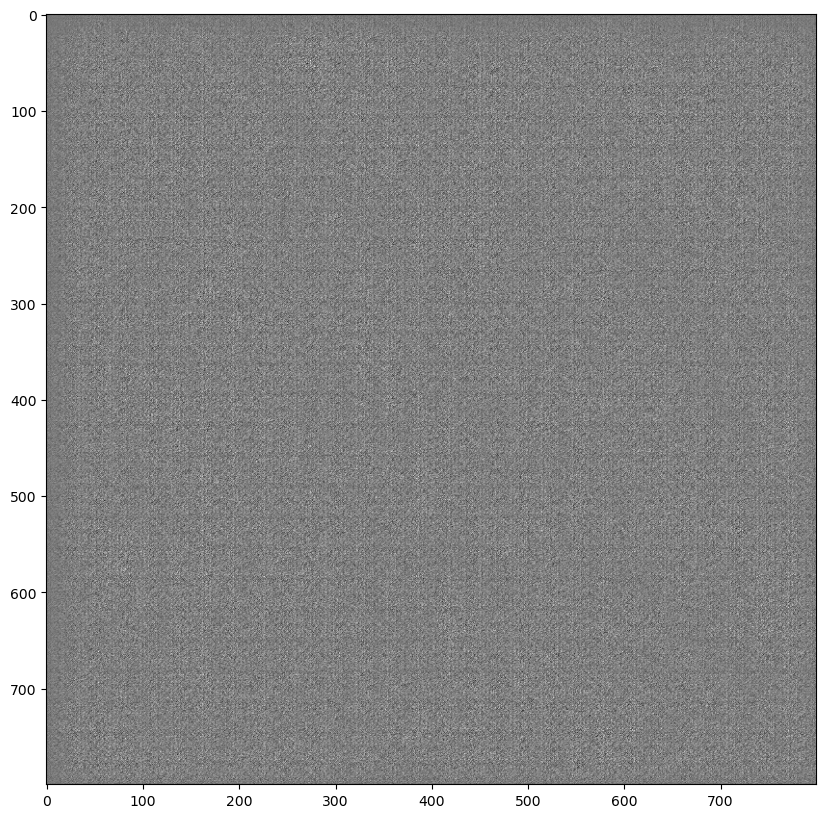

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

In [11]:
def make_discriminator_model():
    input_1 = Input(shape=(800, 800, 1), name = "Input_image")
    x = Conv2D(16, (11, 11), strides=(2, 2), padding='same')(input_1)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (9, 9), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    model = Model(inputs=input_1, outputs=x)

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[1.0291728e-05]], shape=(1, 1), dtype=float32)


In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_dir = 'training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [15]:
EPOCHS = 6000
noise_dim = 100
num_examples_to_generate = 1

seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 500 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [16]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  plt.figure(figsize=(12, 12))
  plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.savefig('epochs/image_at_epoch_{:04d}.png'.format(epoch), bbox_inches='tight', pad_inches=0)
  plt.show()

In [17]:
train(train_dataset, EPOCHS)

NameError: name 'time' is not defined

In [ ]:
generator.save_weights('saved_weights/generator_weights.h5')
discriminator.save_weights('saved_weights/discriminator_weights.h5')

print("Weights have been saved.")

: 

: 